In [12]:
import numpy as np

np.random.seed(42)

import glob
import os
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt

from src.data_util import load_preprocess_examples
import seaborn as sns

fs = 18
plt.rcParams.update({"font.size": fs})
# set layout-theme
sns.set_theme(style="white", context="talk")
plt.rcParams.update({"font.size": 12})
plt.rcParams["axes.grid"] = True
sns.set(font_scale=1.8)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.8)

In [13]:
hist_pig_dict = {}
load_path = "/data/PulHypStudie_Check_npz_v2/"

for P in ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]:
    samples = len(os.listdir(load_path + P))
    hist_pig_dict[P] = samples
    print(P, samples)

dap_factor = 180
sap_factor = 180
map_factor = 160

P_01_PulHyp 10338
P_02_PulHyp 12859
P_03_PulHyp 8124
P_04_PulHyp 8914
P_05_PulHyp 10063
P_06_PulHyp 6934
P_07_PulHyp 5692
P_08_PulHyp 7189
P_09_PulHyp 8228
P_10_PulHyp 6552


In [14]:
try:
    os.mkdir("/data/PulHypStudie_Check_npz_v3_SNR30")
except:
    print("Exists")

In [15]:
for P in range(1, 11):
    try:
        os.mkdir("/data/PulHypStudie_Check_npz_v3_SNR30/P_{0:02d}_PulHyp".format(P))
    except BaseException:
        print("Skip", P)

In [16]:
max_samples = 15_000
test_limit = 500

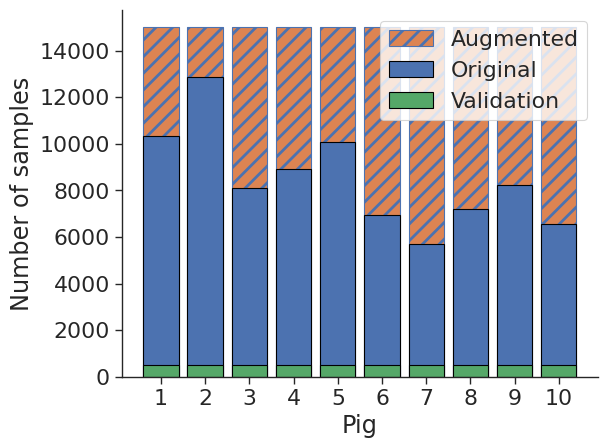

In [17]:
values = list(hist_pig_dict.values())

plt.rcParams["hatch.linewidth"] = 2
for i, v in enumerate(values):
    # if i == 6:
    #    pass
    # else:
    plt.bar(i, max_samples, color="C1", edgecolor="C0", hatch="//")
    plt.bar(i, v, color="C0", edgecolor="black")
    plt.bar(i, test_limit, color="C2", edgecolor="black")
    # plt.bar(6,values[6], color='C3',edgecolor="black")
plt.xticks(ticks=np.arange(0, 10), labels=np.arange(1, 11))
plt.ylabel("Number of samples")
plt.xlabel("Pig")
plt.legend(["Augmented", "Original", "Validation"])
plt.tight_layout()
# plt.savefig("images/hist_pig_samples_aug_v2.png")
# plt.savefig("images/hist_pig_samples_aug_v2.pdf")
# plt.savefig("images/hist_pig_samples_aug_v2.svg")
plt.show()

## Automation

In [18]:
def add_noise_2d(signal, snr_db=30):  #  SNR definition
    signal_power = np.mean(signal**2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise


def copy_sample(idx, eit, y, pig, aug_path):
    np.savez(
        aug_path + "sample_{0:06d}.npz".format(idx),
        eit=eit,
        y=y,
        pig=pig,
    )


def augment_sample(idx, eit, y, pig, aug_path):
    np.savez(
        aug_path + "sample_{0:06d}.npz".format(idx),
        eit=add_noise_2d(eit),
        y=y,
        pig=pig,
    )


for SELECTED_PIG in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:  #  exclude 7
    print(SELECTED_PIG)
    # l_path = "/data/PulHyp_and_SVV_npz/"
    l_path = "/data/PulHypStudie_Check_npz_v2/"
    pig_path = ["P_{0:02d}_PulHyp".format(i) for i in [SELECTED_PIG]]

    aug_path = "/data/PulHypStudie_Check_npz_v3_SNR30/" + pig_path[0] + "/"

    X, y, clrs_pig = load_preprocess_examples(
        l_path,
        pig_path,
        sap=True,
        get_pig=True,
        shuffle=False,
        norm_eit="block",
        quality_check=False,
    )

    y[:, 0] = y[:, 0] / dap_factor  # dap normalization
    y[:, 1] = y[:, 1] / sap_factor  # sap normalization
    y[:, 2] = y[:, 2] / map_factor  # map normalization

    available = np.arange(0, hist_pig_dict[pig_path[0]])
    print("available.shape=", available.shape, "X.shape=", X.shape)

    cpus = int(64)
    pool = Pool()
    for idx in available:
        pool.apply_async(
            copy_sample, args=(idx, X[idx, :, :, 0], y[idx], clrs_pig[idx], aug_path)
        )
    pool.close()

    augmented = np.arange(hist_pig_dict[pig_path[0]], max_samples)
    n_samples_curr_pig = hist_pig_dict[pig_path[0]]
    aug_num = max_samples - n_samples_curr_pig
    print(f"There are {n_samples_curr_pig}, {aug_num} will be created.")

    sel_from_sample = np.random.randint(
        test_limit, n_samples_curr_pig, size=aug_num
    )  # exclude the first 250 for testing -> Green

    cpus = int(32)
    pool = Pool()
    for i, idx in enumerate(augmented):
        pool.apply_async(
            augment_sample,
            args=(
                idx,
                X[sel_from_sample[i], :, :, 0],
                y[sel_from_sample[i]],
                clrs_pig[sel_from_sample[i]],
                aug_path,
            ),
        )
    pool.close()

1
Loading data from /data/PulHypStudie_Check_npz_v2/P_01_PulHyp
available.shape= (10338,) X.shape= (10338, 64, 1024, 1)
There are 10338, 4662 will be created.
2
Loading data from /data/PulHypStudie_Check_npz_v2/P_02_PulHyp
available.shape= (12859,) X.shape= (12859, 64, 1024, 1)
There are 12859, 2141 will be created.
3
Loading data from /data/PulHypStudie_Check_npz_v2/P_03_PulHyp
available.shape= (8124,) X.shape= (8124, 64, 1024, 1)
There are 8124, 6876 will be created.
4
Loading data from /data/PulHypStudie_Check_npz_v2/P_04_PulHyp
available.shape= (8914,) X.shape= (8914, 64, 1024, 1)
There are 8914, 6086 will be created.
5
Loading data from /data/PulHypStudie_Check_npz_v2/P_05_PulHyp
available.shape= (10063,) X.shape= (10063, 64, 1024, 1)
There are 10063, 4937 will be created.
6
Loading data from /data/PulHypStudie_Check_npz_v2/P_06_PulHyp
available.shape= (6934,) X.shape= (6934, 64, 1024, 1)
There are 6934, 8066 will be created.
7
Loading data from /data/PulHypStudie_Check_npz_v2/P_0

In [20]:
for P in ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]:
    print(len(os.listdir("/data/PulHypStudie_Check_npz_v3_SNR30/" + P)))

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000


In [21]:
### Offset test

In [22]:
tmp = np.load(
    "/data/PulHypStudie_Check_npz_v3_SNR30/P_01_PulHyp/sample_000000.npz",
    allow_pickle=True,
)
tmp.files

['eit', 'y', 'pig']

### Archive

**Parallel processing**

_Copy present samples_

In [ ]:
l_path = "/data/PulHyp_and_SVV_npz/"
SELECTED_PIG = 1

pig_path = ["P_{0:02d}_PulHyp".format(i) for i in [SELECTED_PIG]]

aug_path = "/data/PulHyp_augmented_SNR30/" + pig_path[0] + "/"

X, y, clrs_pig = load_preprocess_examples(
    l_path,
    pig_path,
    sap=True,
    get_pig=True,
    shuffle=False,
    norm_eit="block",
)

y[:, 0] = y[:, 0] / dap_factor  # dap normalization
y[:, 1] = y[:, 1] / sap_factor  # sap normalization
y[:, 2] = y[:, 2] / map_factor  # map normalization

In [ ]:
print(X.shape, y.shape, clrs_pig.shape)

In [ ]:
aug_path

**Copy available data**

In [27]:
available = np.arange(0, hist_pig_dict[pig_path[0]])
available

array([    0,     1,     2, ..., 10415, 10416, 10417])

In [28]:
cpu_count()

256

In [29]:
cpus = int(128)


def copy_sample(idx, eit, y, pig, aug_path):
    np.savez(
        aug_path + "sample_{0:06d}.npz".format(idx),
        eit=eit,
        y=y,
        pig=pig,
    )


pool = Pool()
for idx in available:
    pool.apply_async(
        copy_sample, args=(idx, X[idx, :, :, 0], y[idx], clrs_pig[idx], aug_path)
    )
pool.close()

In [30]:
tmp = np.load(
    "/data/PulHyp_augmented_SNR30/P_01_PulHyp/sample_000000.npz", allow_pickle=True
)
tmp.files

['eit', 'y', 'pig']

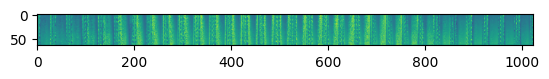

In [31]:
plt.imshow(tmp["eit"])

In [40]:
len(os.listdir("/data/PulHyp_augmented_SNR30/P_01_PulHyp/"))

10418

**Augment data**

In [41]:
augmented = np.arange(hist_pig_dict[pig_path[0]], max_samples)
augmented

array([10418, 10419, 10420, ..., 14997, 14998, 14999])

In [42]:
n_samples_curr_pig = hist_pig_dict[pig_path[0]]
aug_num = max_samples - n_samples_curr_pig
print(f"There are {n_samples_curr_pig}, {aug_num} will be created.")

sel_from_sample = np.random.randint(0, n_samples_curr_pig, size=aug_num)

There are 10418, 4582 will be created.


In [43]:
def add_noise_2d(signal, snr_db=20):
    signal_power = np.mean(signal**2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

In [44]:
def augment_sample(idx, eit, y, pig, aug_path):
    np.savez(
        aug_path + "sample_{0:06d}.npz".format(idx),
        eit=add_noise_2d(eit),
        y=y,
        pig=pig,
    )

In [45]:
cpus = int(128)

pool = Pool()
for i, idx in enumerate(augmented):
    pool.apply_async(
        augment_sample,
        args=(
            idx,
            X[sel_from_sample[i], :, :, 0],
            y[sel_from_sample[i]],
            clrs_pig[sel_from_sample[i]],
            aug_path,
        ),
    )
pool.close()

In [49]:
tmp = np.load(
    "/data/PulHyp_augmented_SNR30/P_01_PulHyp/sample_014999.npz", allow_pickle=True
)
tmp.files

['eit', 'y', 'pig']

In [50]:
print(tmp["y"], tmp["pig"])

[0.28584103 0.41194331 0.39906507] ['Pig_01' 'block_06' 'PulHyp']


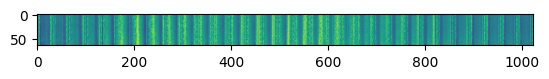

In [51]:
plt.imshow(tmp["eit"])

In [52]:
len(os.listdir("/data/PulHyp_augmented_SNR30/P_01_PulHyp/"))

15000

___